## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 5765k    0     0  6088k      0  0:02:12 --:--:--  0:02:12 6081k
  1  786M    1 10.2M    0     0  5346k      0  0:02:30  0:00:01  0:02:29 5343k
  1  786M    1 14.7M    0     0  5128k      0  0:02:37  0:00:02  0:02:35 5127k
  2  786M    2 19.2M    0     0  5002k      0  0:02:41  0:00:03  0:02:38 5000k
  3  786M    3 23.8M    0     0  4937k      0  0:02:43  0:00:04  0:02:39 4936k
  3  786M    3 28.4M    0     0  4896k      0  0:02:44  0:00:05  0:02:39 4670k
  4  786M    4 32.9M    0     0  4860k      0  0:02:45  0:00:06  0:02:39 4670k
  4  786M    4 37.5M    0     0  4840k      0  0:02:46  0:00:07  0:02:39 4671k
  5  786M    5 42.1M    0     0  4817k      0  0:02:47  0:00:08  0:02:39 4672k
  5  786M    5 46.6M    0     0  4807k      0  0:02

In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


01 learning process.ipynb
MSR-LA - 3467.docx
Memory-database.accdb
PetImages
kagglecatsanddogs_3367a.zip
main.py
readme[1].txt


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [1]:
image_dir = 'data/PetImages/train'
holdout_dir = 'data/PetImages/holdout'
!ls $image_dir

Cat
Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(image_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1578 images


In [17]:
!ls $image_dir

Cat
Dog


## Generate a `Dataset`


In [2]:
from dataset_generating import split_train_holdout

In [3]:
split_train_holdout(path_to_data=image_dir, path_to_holdout=holdout_dir, holdout_ratio=0.1)

holdout_counter {'Cat': 1175, 'Dog': 1168}
move holdout_counter 1175 to data/PetImages/holdout\Cat
move holdout_counter 1168 to data/PetImages/holdout\Dog


In [20]:
import tensorflow as tf

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [13]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
for d in train_ds:
    print(len(d), d[0].shape, d[1].shape)
    break

2 (32, 180, 180, 3) (32,)


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


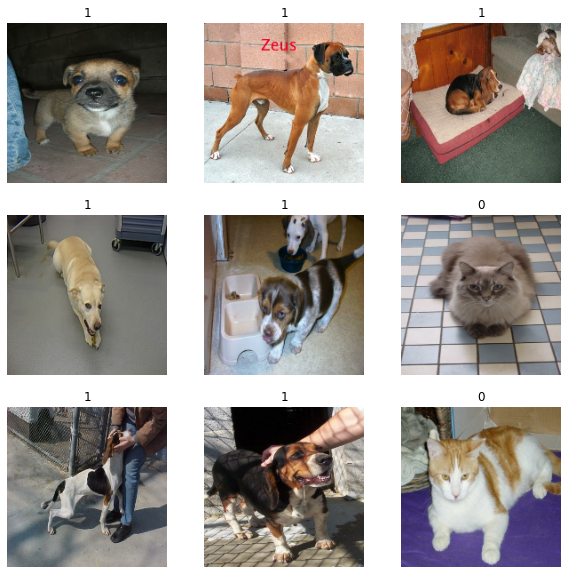

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [19]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


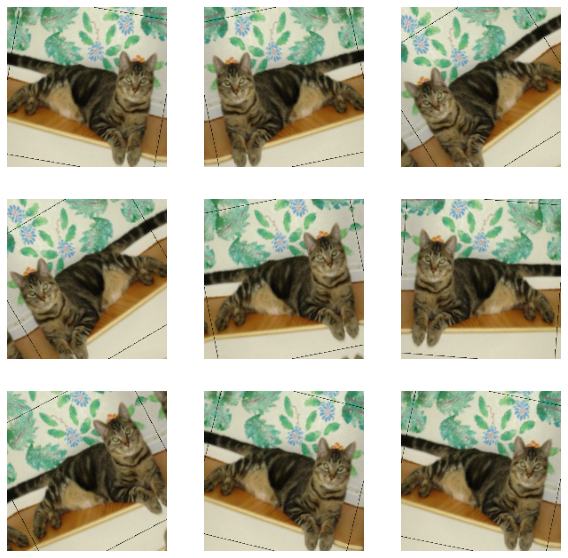

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.
